In [ ]:
#---------Code for datafile creation------------
        #import pandas as pd
        #trainDF=pd.read_csv('demand-forecasting/train.csv')
        #testDF=pd.read_csv('demand-forecasting/test.csv')
        #testDF['date'] = pd.to_datetime(testDF['date'], format="%Y-%m-%d")

        #trainDF['year'] = trainDF['date'].dt.year
        #testDF['year'] = testDF['date'].dt.year

        #select only 20 items
        #s = 20
        #train_df1 = trainDF[trainDF['item'] <= s]
        #test_df1 = testDF[testDF['item'] <= s]

        #select only 5 stores
        #st = 5
        #train_df2 = train_df1[train_df1['store'] <= st]
        #test_df2 = test_df1[test_df1['store'] <= st]

        #select only 3 years
        #yr = 2015
        #train_df3 = train_df2[train_df2['year'] >= yr]

        #final data file
        #train_df3.to_csv('train.csv',index=False);
        #test_df2.to_csv('test.csv',index=False);

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from numpy.random import seed
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pandas import concat

#load new data file for training data
data=pd.read_csv('train.csv')
testDF=pd.read_csv('test.csv')
#drop rows if they contain null values
data.dropna(axis = 0, how ='any')

#format date column
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data['year'] = data['date'].dt.year
testDF['date'] = pd.to_datetime(testDF['date'], format="%Y-%m-%d")
testDF['year'] = testDF['date'].dt.year

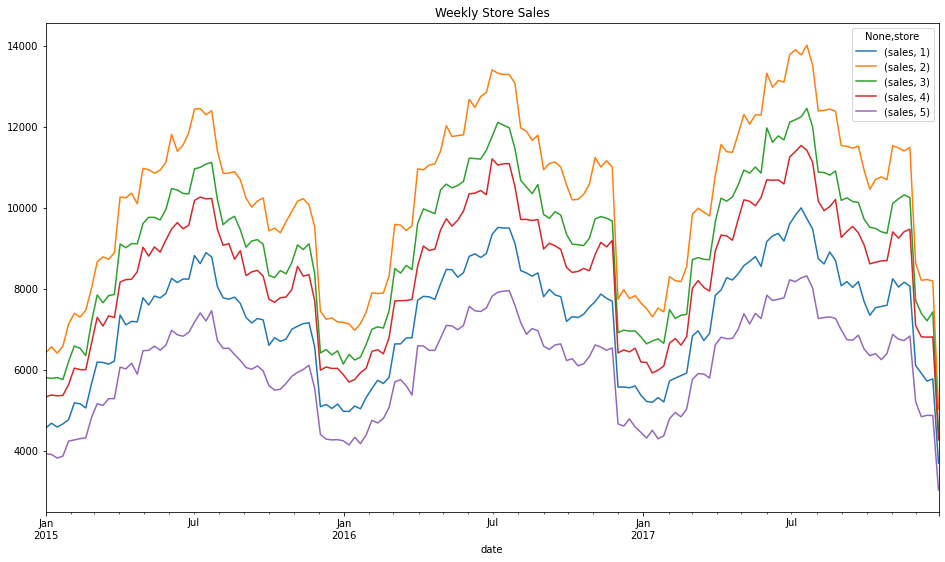

In [2]:
#plot for EDA
stores = pd.DataFrame(data.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)
stores.plot(figsize=(16,9), title='Weekly Store Sales')
plt.show()

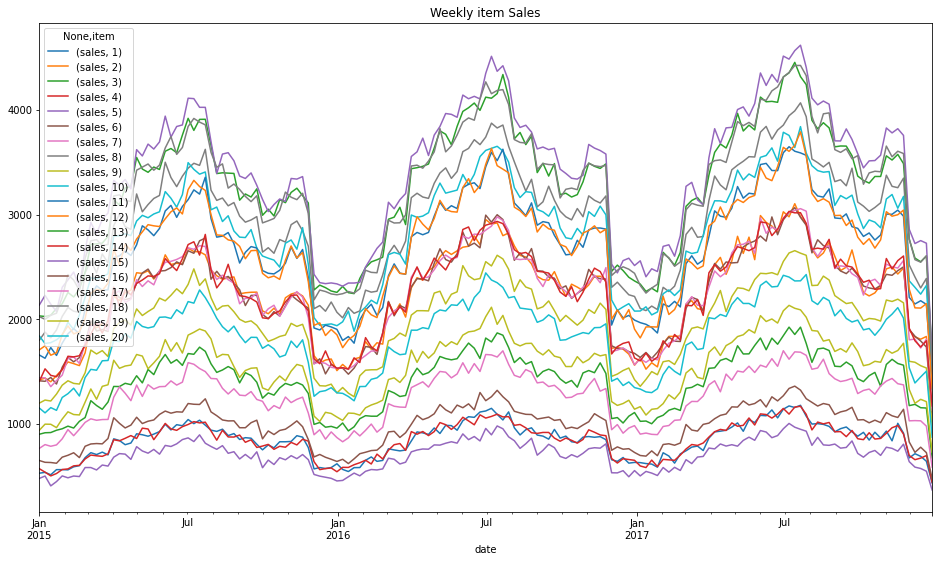

In [3]:
#plot for EDA
stores = pd.DataFrame(data.groupby(['date','item']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)
stores.plot(figsize=(16,9), title='Weekly item Sales')
plt.show()

In [4]:
print('Max date from train set: %s' % data['date'].max().date())

Max date from train set: 2017-12-31


In [5]:
#------------Model 1 Implementaion start-----------------

In [6]:
#lag size for 90days
lag_size = (testDF['date'].max().date() - data['date'].max().date()).days

#rearrange dataset for shifting
train_group = data.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_group = train_group.agg({'sales':['mean']})
train_group.columns = ['item', 'store', 'date', 'sales']
train_group.head()

,item,store,date,sales
0,1,1,2015-01-01,11
1,1,1,2015-01-02,19
2,1,1,2015-01-03,16
3,1,1,2015-01-04,14
4,1,1,2015-01-05,14


In [7]:
#convert data set to a time series problem
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
#30 days
window = 29
lag = lag_size
series = series_to_supervised(train_group.drop('date', axis=1), window=window, lag=lag)
series

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,11.0,1.0,1.0,19.0,1.0,1.0,16.0,1.0,...,13.0,1.0,1.0,7.0,1,1,12,1.0,1.0,27.0
30,1.0,1.0,19.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,7.0,1.0,1.0,12.0,1,1,19,1.0,1.0,20.0
31,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,14.0,1.0,...,12.0,1.0,1.0,19.0,1,1,17,1.0,1.0,22.0
32,1.0,1.0,14.0,1.0,1.0,14.0,1.0,1.0,9.0,1.0,...,19.0,1.0,1.0,17.0,1,1,6,1.0,1.0,33.0
33,1.0,1.0,14.0,1.0,1.0,9.0,1.0,1.0,13.0,1.0,...,17.0,1.0,1.0,6.0,1,1,10,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109505,20.0,5.0,35.0,20.0,5.0,38.0,20.0,5.0,54.0,20.0,...,47.0,20.0,5.0,31.0,20,5,40,20.0,5.0,37.0
109506,20.0,5.0,38.0,20.0,5.0,54.0,20.0,5.0,40.0,20.0,...,31.0,20.0,5.0,40.0,20,5,42,20.0,5.0,29.0
109507,20.0,5.0,54.0,20.0,5.0,40.0,20.0,5.0,51.0,20.0,...,40.0,20.0,5.0,42.0,20,5,48,20.0,5.0,26.0
109508,20.0,5.0,40.0,20.0,5.0,51.0,20.0,5.0,35.0,20.0,...,42.0,20.0,5.0,48.0,20,5,43,20.0,5.0,36.0


In [9]:
#drop rows which are not equal to shifted columns
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]
series

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,11.0,1.0,1.0,19.0,1.0,1.0,16.0,1.0,...,13.0,1.0,1.0,7.0,1,1,12,1.0,1.0,27.0
30,1.0,1.0,19.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,7.0,1.0,1.0,12.0,1,1,19,1.0,1.0,20.0
31,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,14.0,1.0,...,12.0,1.0,1.0,19.0,1,1,17,1.0,1.0,22.0
32,1.0,1.0,14.0,1.0,1.0,14.0,1.0,1.0,9.0,1.0,...,19.0,1.0,1.0,17.0,1,1,6,1.0,1.0,33.0
33,1.0,1.0,14.0,1.0,1.0,9.0,1.0,1.0,13.0,1.0,...,17.0,1.0,1.0,6.0,1,1,10,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109505,20.0,5.0,35.0,20.0,5.0,38.0,20.0,5.0,54.0,20.0,...,47.0,20.0,5.0,31.0,20,5,40,20.0,5.0,37.0
109506,20.0,5.0,38.0,20.0,5.0,54.0,20.0,5.0,40.0,20.0,...,31.0,20.0,5.0,40.0,20,5,42,20.0,5.0,29.0
109507,20.0,5.0,54.0,20.0,5.0,40.0,20.0,5.0,51.0,20.0,...,40.0,20.0,5.0,42.0,20,5,48,20.0,5.0,26.0
109508,20.0,5.0,40.0,20.0,5.0,51.0,20.0,5.0,35.0,20.0,...,42.0,20.0,5.0,48.0,20,5,43,20.0,5.0,36.0


In [10]:
#drop unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
series

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
29,11.0,19.0,16.0,14.0,14.0,9.0,13.0,18.0,18.0,17.0,...,8.0,14.0,20.0,19.0,12.0,13.0,13.0,7.0,12,27.0
30,19.0,16.0,14.0,14.0,9.0,13.0,18.0,18.0,17.0,19.0,...,14.0,20.0,19.0,12.0,13.0,13.0,7.0,12.0,19,20.0
31,16.0,14.0,14.0,9.0,13.0,18.0,18.0,17.0,19.0,9.0,...,20.0,19.0,12.0,13.0,13.0,7.0,12.0,19.0,17,22.0
32,14.0,14.0,9.0,13.0,18.0,18.0,17.0,19.0,9.0,9.0,...,19.0,12.0,13.0,13.0,7.0,12.0,19.0,17.0,6,33.0
33,14.0,9.0,13.0,18.0,18.0,17.0,19.0,9.0,9.0,15.0,...,12.0,13.0,13.0,7.0,12.0,19.0,17.0,6.0,10,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109505,35.0,38.0,54.0,40.0,51.0,35.0,43.0,39.0,39.0,49.0,...,35.0,39.0,36.0,47.0,42.0,33.0,47.0,31.0,40,37.0
109506,38.0,54.0,40.0,51.0,35.0,43.0,39.0,39.0,49.0,57.0,...,39.0,36.0,47.0,42.0,33.0,47.0,31.0,40.0,42,29.0
109507,54.0,40.0,51.0,35.0,43.0,39.0,39.0,49.0,57.0,44.0,...,36.0,47.0,42.0,33.0,47.0,31.0,40.0,42.0,48,26.0
109508,40.0,51.0,35.0,43.0,39.0,39.0,49.0,57.0,44.0,42.0,...,47.0,42.0,33.0,47.0,31.0,40.0,42.0,48.0,43,36.0


In [11]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

x_train, x_test, y_train, y_test = train_test_split(series, labels.values, test_size=0.2, random_state=0)
x_train

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
81203,56.0,53.0,49.0,50.0,51.0,43.0,53.0,52.0,71.0,56.0,...,71.0,77.0,66.0,73.0,74.0,61.0,81.0,50.0,62.0,70
21342,20.0,18.0,13.0,31.0,21.0,20.0,32.0,23.0,23.0,21.0,...,16.0,19.0,15.0,21.0,20.0,22.0,16.0,20.0,24.0,29
68779,101.0,111.0,106.0,123.0,77.0,87.0,92.0,91.0,101.0,111.0,...,106.0,86.0,107.0,120.0,141.0,84.0,96.0,110.0,123.0,137
59957,48.0,47.0,32.0,44.0,31.0,56.0,51.0,38.0,59.0,31.0,...,45.0,49.0,48.0,33.0,42.0,48.0,43.0,59.0,42.0,44
52210,67.0,91.0,84.0,93.0,109.0,130.0,116.0,66.0,69.0,106.0,...,107.0,80.0,96.0,106.0,97.0,95.0,98.0,105.0,78.0,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21823,23.0,22.0,11.0,21.0,26.0,18.0,24.0,21.0,22.0,19.0,...,26.0,12.0,15.0,20.0,21.0,17.0,28.0,27.0,22.0,15
47167,54.0,30.0,25.0,27.0,35.0,41.0,41.0,55.0,25.0,35.0,...,42.0,51.0,27.0,39.0,38.0,53.0,48.0,48.0,47.0,28
43773,78.0,68.0,71.0,72.0,76.0,65.0,50.0,51.0,63.0,69.0,...,65.0,64.0,55.0,63.0,76.0,73.0,54.0,48.0,66.0,56
44756,47.0,69.0,66.0,74.0,80.0,63.0,35.0,75.0,45.0,65.0,...,50.0,57.0,59.0,66.0,57.0,85.0,79.0,65.0,48.0,66


In [12]:
#hyperparameter optimization for XGBoost and define the space
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'n_estimators':1000 ,
        'subsample': hp.uniform ('subsample', 0,1),
        'eta': hp.uniform ('eta', 0,1),
        'seed': 0
    }

In [13]:
#define objective function
def objective(space):
    model=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    subsample=space['subsample'],  eta=space['eta'],seed=space['seed']
                    )
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred<18, squared=False)
    return {'loss': -mse, 'status': STATUS_OK }

In [14]:
#finding best hyperparameters
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [14:30<00:00,  8.71s/trial, best loss: -67.31053236029277]


In [14]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5341362852251963, 'eta': 0.003990662781227616, 'gamma': 3.2763135542721016, 'max_depth': 8.0, 'min_child_weight': 4.0, 'reg_alpha': 85.0, 'reg_lambda': 0.006874470645580888, 'subsample': 0.5217991560497965}


In [15]:
#set best hyperparameters to train the model
model = xgb.XGBRegressor(
    max_depth=int(best_hyperparams['max_depth']),
    min_child_weight=best_hyperparams['min_child_weight'], 
    gamma=best_hyperparams['gamma'],
    reg_alpha=best_hyperparams['reg_alpha'],
    reg_lambda=best_hyperparams['reg_lambda'],
    eta=best_hyperparams['eta'],
    subsample=best_hyperparams['subsample'],
    colsample_bytree=best_hyperparams['colsample_bytree']
    )


model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=10,
    verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5341362852251963,
             eta=0.003990662781227616, gamma=3.2763135542721016, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.00399066275, max_delta_step=0, max_depth=8,
             min_child_weight=4.0, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=85.0, reg_lambda=0.006874470645580888,
             scale_pos_weight=1, subsample=0.5217991560497965,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
#forcast for next 3 months
y_pred = model.predict(x_test)

#root mean squared error 
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Square Error:',round(rmse,2))

Root Mean Square Error: 47.14


In [17]:
# Plot the forecast with the actuals
val=pd.DataFrame()
val['y_pred'] = y_pred
val['y_test']=y_test
val

,y_pred,y_test
0,15.999127,65.0
1,19.401625,71.0
2,11.761145,45.0
3,18.418291,50.0
4,11.589118,54.0
...,...,...
21317,9.557034,53.0
21318,9.717819,16.0
21319,26.567757,85.0
21320,23.935488,64.0


<AxesSubplot:>

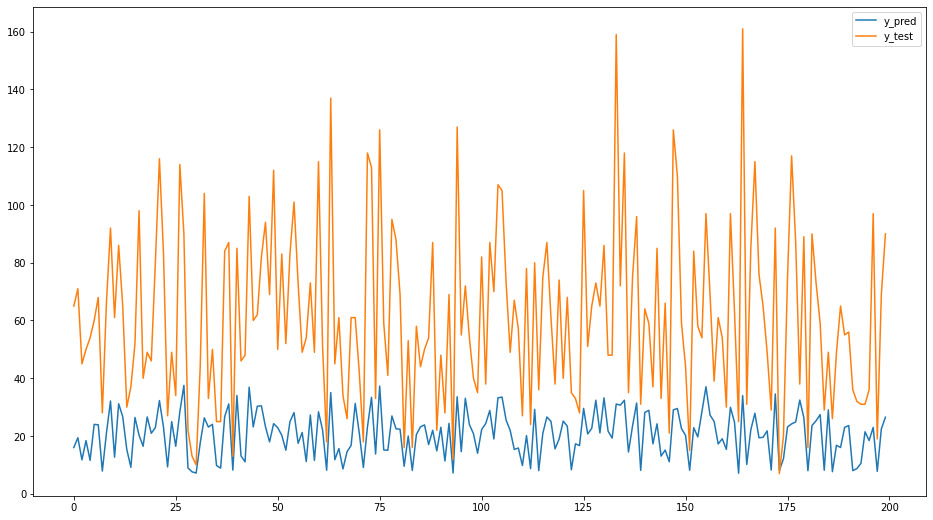

In [18]:
val[0:200].plot(figsize=(16,9))

In [ ]:
#------------Model 1 Implementaion End-----------------

In [ ]:
#--------------Model 2 Implementation Start---------------------------

In [ ]:
#load new data file for training data
data=pd.read_csv('train.csv')
testDF=pd.read_csv('test.csv')
#drop rows if they contain null values
data.dropna(axis = 0, how ='any')

#format date column
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data['year'] = data['date'].dt.year
testDF['date'] = pd.to_datetime(testDF['date'], format="%Y-%m-%d")
testDF['year'] = testDF['date'].dt.year

In [ ]:
#divide dataset to train and test, test dataset includes last 3 months
x_train = data.loc[data['date'] < pd.to_datetime('October 3, 2017')].drop(['sales','year','date'], axis=1)
y_train = data.loc[data['date'] < pd.to_datetime('October 3, 2017'), 'sales']
x_testD = data.loc[data['date'] >= pd.to_datetime('October 3, 2017')].drop(['year'], axis=1).reset_index(drop=True)
x_test = data.loc[data['date'] >= pd.to_datetime('October 3, 2017')].drop(['sales','year','date'], axis=1).reset_index(drop=True)
y_test = data.loc[data['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].reset_index(drop=True)

In [ ]:
#hyperparameter optimization for XGBoost and define the space
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'n_estimators':1000 ,
        'subsample': hp.uniform ('subsample', 0,1),
        'eta': hp.uniform ('eta', 0,1),
        'seed': 0
    }

In [ ]:
#define objective function
def objective(space):
    model=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    subsample=space['subsample'],  eta=space['eta'],seed=space['seed']
                    )
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred<18, squared=False)
    return {'loss': -mse, 'status': STATUS_OK }

In [ ]:
#finding best hyperparameters
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
#set best hyperparameters to train the model
model = xgb.XGBRegressor(
    max_depth=int(best_hyperparams['max_depth']),
    min_child_weight=best_hyperparams['min_child_weight'], 
    gamma=best_hyperparams['gamma'],
    reg_alpha=best_hyperparams['reg_alpha'],
    reg_lambda=best_hyperparams['reg_lambda'],
    eta=best_hyperparams['eta'],
    subsample=best_hyperparams['subsample'],
    colsample_bytree=best_hyperparams['colsample_bytree']
    )


model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=10,
    verbose=False)

In [ ]:
#forcast for next 3 months
y_pred = model.predict(x_test)

#root mean squared error 
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Square Error:',round(rmse,2))

In [ ]:
# Plot the forecast with the actuals
val=pd.DataFrame()
val['y_pred'] = y_pred
val['y_test']=y_test
val

In [ ]:
#Plot Actual vs Prediction
val[0:2000].plot(figsize=(16,9))

In [ ]:
#--------------Model 2 Implementation End---------------------------